<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/bridge_observations_tps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processing Bridge Observations

##Import neccessary Python packages

In [63]:
import re                         # for regular expressions
import numpy as np                # for vector/matri operations
import matplotlib.pyplot as plt   # for charts
import pandas as pd               # for table like data structures
from datetime import datetime, timedelta  # for time/date handling

##Processing Robotic total station data

Download total station data

In [64]:
!gdown --id 1uYYOkjyxWmrFEWwnb96Wk3IBf5nRPzhR -O sample_data/bridge_tps.txt

Downloading...
From: https://drive.google.com/uc?id=1uYYOkjyxWmrFEWwnb96Wk3IBf5nRPzhR
To: /content/sample_data/bridge_tps.txt
100% 142k/142k [00:00<00:00, 87.5MB/s]


Unfortunately in the space delimited text file there are spaces in the time if minute or second are less than ten. Using grep let's display the first 10 of these rows from the file. Another issue is that the seconds are sometimes 60, what Python marks as error.

```
TPS1200        -15.6389   198.3699    4.7584    --------  0.006  15:10:58
TPS1201        -15.6390   198.3699    4.7599    --------  0.006  15:10:59
TPS1202        -15.6373   198.3701    4.7584    --------  0.006  15:10:60
TPS1203        -15.6360   198.3702    4.7585    --------  0.006  15:11: 1
TPS1204        -15.6374   198.3701    4.7574    --------  0.006  15:11: 2
TPS1205        -15.6399   198.3700    4.7531    --------  0.006  15:11: 3
TPS1206        -15.6371   198.3691    4.7556    --------  0.006  15:11: 4
```

Let's write a short Python program to correct these issues.

In [65]:
pattern = re.compile('[0-2][0-9]:[0-6][0-9]:60')  # pattern for 60 seconds
with open('sample_data/bridge_tps.txt') as fp:    # input file
  with open('sample_data/tps.txt', 'w') as fo:    # output file
    for line in fp:
      line = line.replace(': ', ':0')             # space in minutes or seconds
      p = pattern.search(line)                    # are there 60 seconds?
      if p:                                       # there is :60 seconds in string
        orig = p.group()                          # save match part
        tm = orig.replace(':60', ':59')           # change to valid time decreasing with 1 second
        t = datetime.strptime(tm, '%H:%M:%S') + timedelta(seconds=1)  # add 1 second back
        line = line.replace(orig, t.strftime('%H:%M:%S')) # convert back to string and replace original
      print(line, end='', file=fo)                # write to output file


Load data into pandas data frame. Please correct the date!

In [66]:
names = ["east", "north", "elev", "dummy", "std", "time"]
rts_data = pd.read_csv('sample_data/tps.txt', sep='\s+', names=names, skiprows=3)
rts_data['time'] = pd.to_datetime('2022-03-10 ' + rts_data['time']) #, format='%H:%M:%S')
print(f'{rts_data.shape[0]} records loaded')

1886 records loaded


Let's plot the RTS data.

Text(0.5, 1.0, 'Elevations')

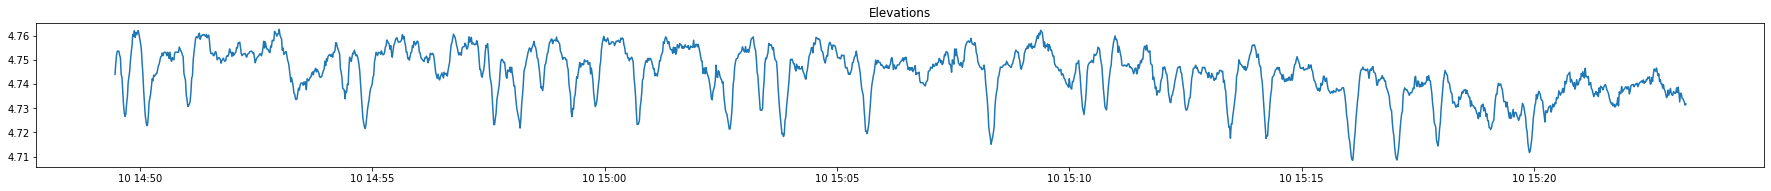

In [67]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(rts_data['time'], rts_data['elev'])
ax.set_title('Elevations')

Do we have gaps in the data serie?

In [68]:
deltas = rts_data['time'].diff()[1:]        # time difference from previous record
dd = deltas[deltas > timedelta(seconds=1)]  # select row where diff > 1 sec
print(f'{rts_data.shape[0]} records with {dd.size} gaps')

1886 records with 143 gaps


Let's fill the gaps.

In [69]:
t0 = rts_data['time'].min()
t0 = datetime(t0.year, t0.month, t0.day, 0, 0, 0)
dt = (rts_data['time'] - t0).dt.total_seconds()  # time difference from midnight
de = rts_data['elev'] - rts_data['elev'].max()
dt = dt.to_numpy().astype(int)
de = (de.to_numpy() * 1000).astype(int)   # change to mm
rts_x = np.arange(dt[0], dt[-1]+1)        # create serie of seconds
rts_y = np.interp(rts_x, dt, de)          # interpolate missing deflection (linear)
print(f'max deflection: {rts_y.min():.1f} mm')

max deflection: -54.0 mm


Let's display chart and critical deflections. Please update *critical* value based on max deflection.

247 seconds under critical


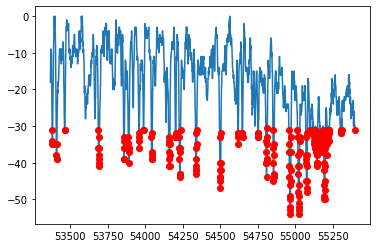

In [70]:
critical = -30                            # critical deflection value
rts = np.c_[rts_x, rts_y]                 # numpy matrix from x, y vectors
rts_bus = rts[rts[:,1] < critical]        # select below critical
print(f'{rts_bus.shape[0]} seconds under critical')
plt.plot(rts_x, rts_y)                    # plot all data
plt.plot(rts_bus[:,0], rts_bus[:,1], 'ro')  # plot critical points

There is a decreasing trend in the data. Let's remove it.

max deflection: -48.9 mm
200 seconds under critical


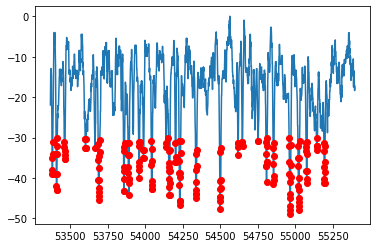

In [71]:
rts_y = rts_y - np.polyval(np.polyfit(rts_x, rts_y, 2), rts_x)  # remove second order trend
rts_y = rts_y - rts_y.max()               # move max deflection value to zero
print(f'max deflection: {rts_y.min():.1f} mm')
rts = np.c_[rts_x, rts_y]                 # numpy matrix from x, y vectors
rts_bus = rts[rts[:,1] < critical]
print(f'{rts_bus.shape[0]} seconds under critical')
plt.plot(rts_x, rts_y)
plt.plot(rts_bus[:,0], rts_bus[:,1], 'ro')

Finaly let's try to estimate bus passes and save them to file.

In [72]:
start = 0                               # start row index of the first bus
bus = []
for i in range(1, rts_bus.shape[0]):    # for each row except first
  if rts_bus[i,0] - rts_bus[i-1,0] > 1: # gap -> new bus arrived
    if i-start-1 > 2:                   # pass longer than 2 seconds?
      bus.append((np.average(rts_bus[start:i,0]),
                  np.min(rts_bus[start:i,1]),
                  i-start-1))           # store time, max deflection and duration (sec)
    start = i
# add last
if rts_bus.shape[0] - start > 2:
  bus.append((np.average(rts_bus[start:,0]),
              np.min(rts_bus[start:,1]),
              rts_bus.shape[0]-start))
print(f'{len(bus)} busses found')
print(f'time  max.defl.  duration')
fo = open('sample_data/rts_bus.txt', 'w')
for b in bus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

23 busses found
time  max.defl.  duration
14:49:41 -39.0     5
14:50:10 -43.1     8
14:51:02 -35.2     5
14:53:21 -32.5     5
14:54:51 -45.5    11
14:57:38 -43.3     7
14:58:09 -44.3     9
14:59:19 -40.1     6
14:59:48 -35.0     3
15:00:43 -42.8     7
15:02:39 -44.2    11
15:03:22 -36.0     4
15:03:50 -46.8    11
15:05:39 -45.0     8
15:08:19 -47.6     9
15:10:18 -34.4     3
15:13:28 -41.1     8
15:14:15 -41.5     6
15:16:04 -48.9    12
15:17:02 -48.0    11
15:17:55 -41.2     8
15:19:04 -33.0     4
15:19:54 -41.2     9


and display them.

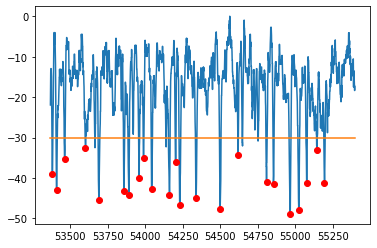

In [73]:
plt.plot(rts_x, rts_y)
plt.plot([rts_x.min(), rts_x.max()], [critical, critical])
plt.plot([b[0] for b in bus], [b[1] for b in bus], 'ro')

##GNSS data processing

This processing is very similar to RTS data processing